In [54]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from abc import ABC, abstractmethod

In [55]:
seed = 5
np.random.seed(seed)

# Scalers

In [56]:
class Scaler(ABC):
    @abstractmethod
    def normalize(self, X: NDArray, update_params: bool = False) -> NDArray:
        pass

    @abstractmethod
    def denormalize(self, X: NDArray) -> NDArray:
        pass

class StandardScaler(Scaler):
    def __init__(self):
        self.mean: NDArray = None
        self.std: NDArray = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        mean = np.mean(X, axis=0) if self.mean is None or update_params else self.mean
        std = np.std(X, axis=0) if self.std is None or update_params else self.std

        self.mean = mean
        self.std = std

        return (X - mean) / std

    def denormalize(self, X: NDArray):
        return X * self.std + self.mean

class MinMaxScaler(Scaler):
    def __init__(self):
        self.min = None
        self.max = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        min = np.min(X, axis=0) if self.min is None or update_params else self.min
        max = np.max(X, axis=0) if self.max is None or update_params else self.max

        self.min = min
        self.max = max

        return (X - min) / (max - min)

    def denormalize(self, X: NDArray):
        return X * (self.max - self.min) + self.min


# OLS model training class

In [57]:
class OLSPolynomialModel:
    def __init__(self, degree: int):
        assert degree > 0, 'Degree must be greater than 0'
        self.w: NDArray = None
        self.in_scaler1 = MinMaxScaler()
        self.in_scaler2 = MinMaxScaler()
        self.out_scaler = StandardScaler()
        self.degree = degree

    def train(self, X: NDArray, y: NDArray, l2: float = 0.0):
        X = self._preprocess_input(X, True)
        y = self._proprocess_output(y, True)

        regularization = l2 * np.eye(X.shape[1])
        regularization[0, 0] = 0
        w = np.linalg.solve(X.T @ X + regularization, X.T @ y)

        self.w = w

    def predict(self, X: NDArray):
        X = self._preprocess_input(X, False)
        y_predict = X @ self.w

        return self.out_scaler.denormalize(y_predict)

    def _preprocess_input(self, X: NDArray, update_params: bool = False):
        '''Normalize, insert ones collumn, insert polynomial collumns'''
        n, m = X.shape
        X_normalized = self.in_scaler1.normalize(X, update_params)
        X_poly = np.zeros((n, 0))
        for degree in range(1, self.degree + 1):
            for j in range(m):
                X_poly = np.c_[X_poly, X_normalized[:, j] ** degree]

        X_processed = self.in_scaler2.normalize(X_poly, update_params)
        X_processed = np.c_[np.ones(n), X_processed]
        return X_processed

    def _proprocess_output(self, y: NDArray, update_params: bool = False):
        return self.out_scaler.normalize(y, update_params)


In [58]:
def MSE(y: NDArray, y_predict: NDArray):
    squared_errors = (y - y_predict)**2
    return np.mean(squared_errors)

def RMSE(y: NDArray, y_predict: NDArray):
    return np.sqrt(MSE(y, y_predict))

def genereate_dataset(filename: str, training_percent: float) -> tuple[NDArray, NDArray, NDArray, NDArray]:
    dataset = np.genfromtxt(filename, delimiter=',')
    np.random.shuffle(dataset)

    n, _ = dataset.shape
    X = dataset[:, :-1]
    y = dataset[:, -1].astype(float).reshape((-1, 1))

    training_size = ceil(n * training_percent)
    return X[:training_size], y[:training_size], X[training_size:], y[training_size:]

def genereate_dataset_k_folds(filename: str, k: int):
    training_percent = 1 / k
    dataset = np.genfromtxt(filename, delimiter=',')

    n, _ = dataset.shape
    X = dataset[:, :-1]
    y = dataset[:, -1].astype(float).reshape((-1, 1))

    training_size = ceil(n * training_percent)
    for i in range(k):
        test_index_start = i * training_size
        test_index_final = (i + 1) * training_size if i < k - 1 else n

        X_test = X[test_index_start:test_index_final]
        y_test = y[test_index_start:test_index_final]
        X_train = np.concatenate([X[:test_index_start], X[test_index_final:]])
        y_train = np.concatenate([y[:test_index_start], y[test_index_final:]])

        yield X_train, y_train, X_test, y_test


def plot_metrics_train_test(metrics_train: NDArray, metrics_test: NDArray, title: str):
    x_range = range(1, len(metrics_train) + 1)
    plt.plot(x_range, metrics_train)
    plt.plot(x_range, metrics_test)
    plt.legend(['Treino', 'Teste'])
    plt.xlabel('Grau do polinômio')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.show()


a) lendo o dataset, separando 80% dos dados para treino e 20% para teste

In [59]:
X_train, y_train, X_test, y_test = genereate_dataset('california.csv', 0.8)

b,c) treinando modelos variando o grau de 1 a 13 **Sem Regularização L2** (L2=0)

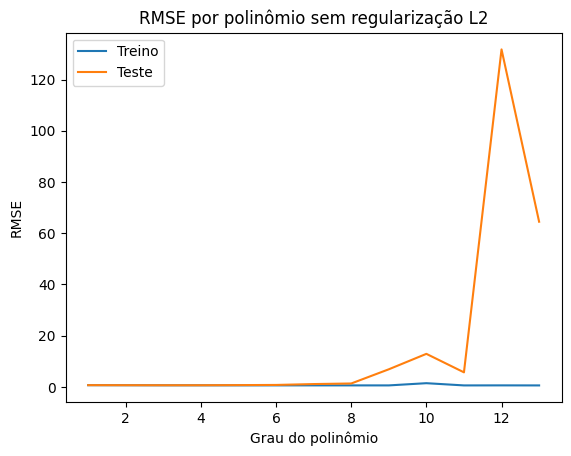

In [60]:
max_degree = 13
models = [
    OLSPolynomialModel(degree=degree)
    for degree in range(1, max_degree + 1)
]

for model in models:
    model.train(X_train, y_train)

metrics_train = [RMSE(y_train, model.predict(X_train)) for model in models]
metrics_test = [RMSE(y_test, model.predict(X_test)) for model in models]

plot_metrics_train_test(metrics_train, metrics_test, 'RMSE por polinômio sem regularização L2')


d) Treinando modelos variando graus de 1 à 13 **Com Regularização L2**

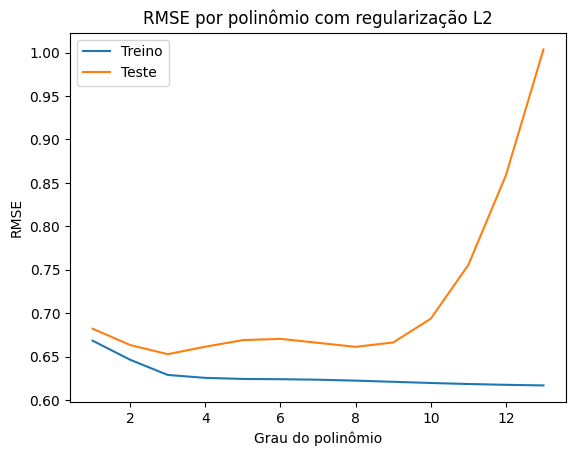

In [61]:
for model in models:
    model.train(X_train, y_train, l2=0.01)

metrics_train = [RMSE(y_train, model.predict(X_train)) for model in models]
metrics_test = [RMSE(y_test, model.predict(X_test)) for model in models]

plot_metrics_train_test(metrics_train, metrics_test, 'RMSE por polinômio com regularização L2')


Treinando os modelos usando K-fold

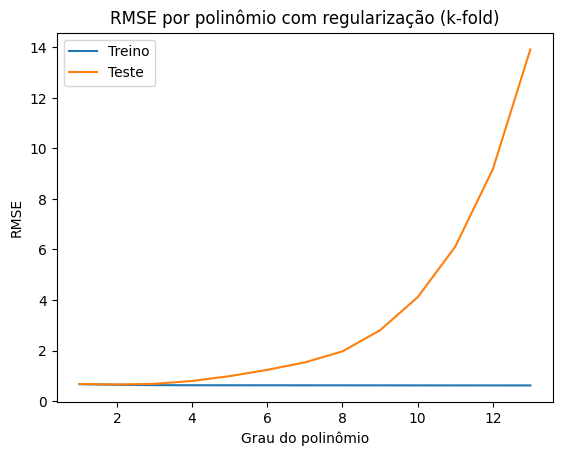

In [62]:
k = 10
k_metrics = np.ndarray((k, max_degree, 2))

for i, (X_train, y_train, X_test, y_test) in enumerate(genereate_dataset_k_folds('california.csv', k)):
    for j, model in enumerate(models):
        model.train(X_train, y_train, l2=0.01)

    for j, model in enumerate(models):
        k_metrics[i][j][0] = RMSE(y_train, model.predict(X_train))
        k_metrics[i][j][1] = RMSE(y_test, model.predict(X_test))

metrics_train = np.mean(k_metrics[:, :, 0], axis=0)
metrics_test = np.mean(k_metrics[:, :, 1], axis=0)

plot_metrics_train_test(metrics_train, metrics_test, 'RMSE por polinômio com regularização (k-fold)')